## Frank Hertz Experiment

### Thermonic emission

Calibration of a filament voltage and accelerating voltage

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [36]:
def chi_squared(x, fit, sig):
     return np.sum(np.square(x-fit)/np.square(sig))

# some fitting forms 

# fitting two lines
def lines(data, *p):
    m1, b1, m2, b2 = p
    one = m1*data+b1
    two = m2*data+b2
    return np.maximum(one, two)


# set up a gaussian with drift
def drift_gauss(data, *p):
    x, t = data.reshape(2, -1)
    A, mu, sigma, drift = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + drift*t

# fitting a line
def line(data, *p):
    m1, b1 = p
    one = m1*data+b1
    return one

# fitting thermonic emission
def therm_exp(data, *p):
    m, b = p
    therm = m*data + b
    #A, W, k, l = p
    #therm =  A * np.exp((data-W)/k)-l
    return np.maximum(therm, 0)

In [37]:
thermon = pd.read_table('calibration.csv', sep=',')
# data got copied wrong
thermon['V_f_2'][5] = 6
thermon.head()

,V_f,V_f_current,V_f_current_unc,V_gc,V_gc_current,V_gc_current_unc,V_f_2,V_f_current_2
0,1.24,-0.001,0.001,57.9,-883.0,1.0,3.001,-0.03
1,4.00,-0.010,0.010,50.0,-760.0,1.0,4.000,-0.06
2,4.50,-0.650,0.010,40.0,-606.0,1.0,4.500,-1.73
3,5.00,-7.510,0.100,30.0,-474.0,1.0,5.000,-15.50
4,5.50,-44.400,0.100,25.0,-418.0,1.0,5.500,-83.30


We fit the contact potential on excitation with no retarding voltage.

In [55]:
# fit the contact potential

volts = thermon['V_gc'][thermon['V_gc']<25]
currents = - thermon['V_gc_current'][thermon['V_gc']<25]
uncerts = thermon['V_gc_current_unc'][thermon['V_gc']<25]+30


# p0 is the initial guess for the fitting coefficients 
p0 = [10, -5]
popt, pcov = curve_fit(therm_exp, volts, currents, p0=p0, sigma=uncerts)
print(popt)
fit_volts = np.linspace(np.min(volts), np.max(thermon['V_gc']), 50)
fit_currents = therm_exp(fit_volts, *popt)

# find the intercept
intercept = popt[1]/popt[0]

# find bounds on the intercepts 
mu_change = 0
b_change=0


#find chi squareds
orig_chi = chi_squared(currents, therm_exp(volts, *popt), uncerts)
up_chi_m = chi_squared(currents, therm_exp(volts, popt[0] + mu_change, popt[1]), uncerts)
down_chi_m = chi_squared(currents, therm_exp(volts, popt[0] - mu_change, popt[1]), uncerts)
print(up_chi_m)
print(down_chi_m)
print('Mu Average Difference: {}\n'.format((up_chi_m+down_chi_m-2*orig_chi)/2))
                                          
up_chi_b = chi_squared(currents, therm_exp(volts, popt[0], popt[1] + b_change), uncerts)
down_chi_b = chi_squared(currents, therm_exp(volts, popt[0], popt[1] + b_change), uncerts)
print('B Average Differnce: {}\n'.format((up_chi_b+down_chi_b-2*orig_chi)/2))                                        

print('Chi: ' + str(orig_chi))
print('dof: '  +str(len(volts)-len(popt)))
print('Reduced Chi: ' + str(orig_chi/(len(volts)-len(popt))))

# find intercept changes
dint = max(abs((popt[1]+b_change)/(popt[0]-mu_change) - intercept), abs((popt[1]-b_change)/(popt[0]+mu_change) -intercept))
print('intercept one: {} +- {}'.format(intercept, dint))

[  35.24291206 -330.45338776]
3.3842816140195975
3.3842816140195975
Mu Average Difference: 0.0

B Average Differnce: 0.0

Chi: 3.3842816140195975
dof: 3
Reduced Chi: 1.1280938713398658
intercept one: -9.376449573904427 +- 0.0


Text(0.27,0.8,'Current at 6.0 V: \n\t 351.0$ \\pm $ 31.0 (stat.)$ \\pm $ 1.0 (syst.)')

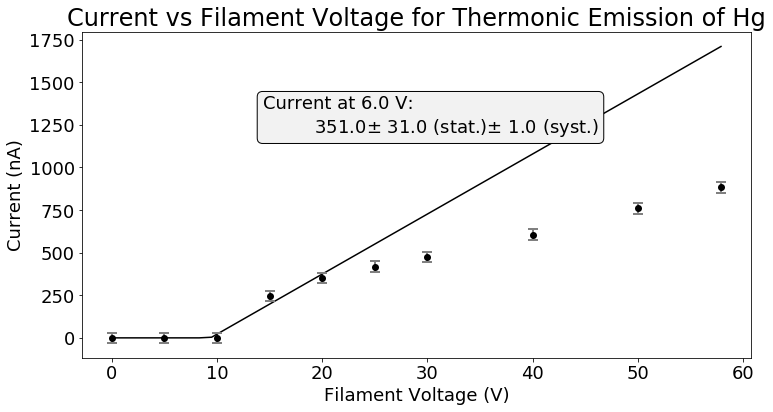

In [56]:
# bined data

bbox = dict(boxstyle="round", fc="0.95")

fig, ax = plt.subplots(1, figsize=(12, 6))

# plot the fit
#log_fit_label = 'Double Linear Fit: \n    I = max({:1.2f}$*V$ {:1.2f}, {:1.2f}$*V$ {:1.2f})'.format(*popt) 
#log_fit_label  = log_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi, len(volts)-len(popt), 0.3192)
ax.plot(fit_volts, fit_currents, 'black', label=log_fit_label)

# plot the intercept/contact potential
#ax.scatter(6, currents[5], marker='x', s=1000, c='r')

# plot the points
ax.errorbar(thermon['V_gc'], -thermon['V_gc_current'], yerr=thermon['V_gc_current_unc']+30, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

# add labesl
ax.set_title('Current vs Filament Voltage for Thermonic Emission of Hg')
ax.set_xlabel('Filament Voltage (V)')
ax.set_ylabel('Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

ax.annotate('Current at 6.0 V: \n\t {:.1f}'.format(currents[5]) + r'$ \pm $' + ' {:.1f} (stat.)'.format(uncerts[5]) + r'$ \pm $' + ' {:.1f} (syst.)'.format(thermon['V_f_current_unc'][5]), 
            xy=(.27, .8), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)

Text(0.27,0.8,'Current at 6.0 V: \n\t -299.5$ \\pm $ 82.4 (stat.)$ \\pm $ 1.0 (syst.)')

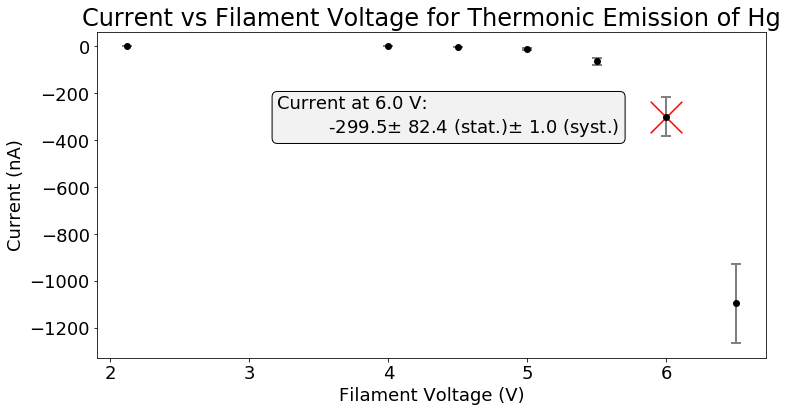

In [57]:
# bined data

bbox = dict(boxstyle="round", fc="0.95")

voltage = (thermon['V_f'] + thermon['V_f_2']) / 2
current = (thermon['V_f_current'] + thermon['V_f_current_2'])/2
err = np.std(np.array([thermon['V_f_current'], thermon['V_f_current_2']]) ,axis=0) /np.sqrt(2)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.scatter(6, current[5], marker='x', s=1000, c='r')
ax.errorbar(voltage, current, yerr=err, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
ax.set_title('Current vs Filament Voltage for Thermonic Emission of Hg')
ax.set_xlabel('Filament Voltage (V)')
ax.set_ylabel('Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

ax.annotate('Current at 6.0 V: \n\t {:.1f}'.format(current[5]) + r'$ \pm $' + ' {:.1f} (stat.)'.format(err[5]) + r'$ \pm $' + ' {:.1f} (syst.)'.format(thermon['V_f_current_unc'][5]), 
            xy=(.27, .8), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)

### Ionization

Effect of temp on mean free path of e-

In [58]:
ionization = pd.read_table('ionization.csv', sep=',')
ionization['temp_current_unc'] = ionization['temp_current_unc']*10
ionization['V_gc_current_unc'] = ionization['V_gc_current_unc']*5
ionization.head()

,temp,temp_current,temp_current_unc,V_gc,V_gc_current,V_gc_current_unc
0,35.0,0.12,0.1,19.80,16.2,0.5
1,52.0,0.20,0.1,19.63,14.7,0.5
2,60.0,1.16,0.1,19.58,14.2,0.5
3,70.0,2.38,0.1,19.55,13.9,0.5
4,79.0,4.24,0.1,19.50,13.6,0.5


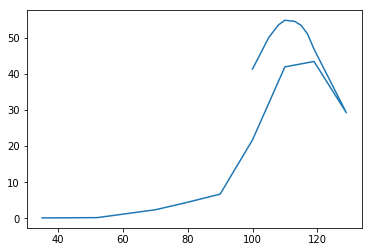

In [59]:
plt.plot(ionization['temp'], ionization['temp_current'])
plt.show()

In [60]:
# we need to correct for the drift in ampmeter
# do as a curve fit for gausian shape around peak with drift param


temps = ionization['temp'][6:18]
times = list()
times.append(0)
for i in range(7, 18):
    times.append(abs(ionization['temp'][i] - ionization['temp'][i-1]) + times[-1])
   # times.append(i)

In [61]:

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [30, 110, 10, .1]
popt, pcov = curve_fit(drift_gauss, np.ravel([temps, times]), ionization['temp_current'][6:18], p0=p0, sigma=ionization['temp_current_unc'][6:18])

print(popt)

[ 39.61379608 113.41010042  12.64227458   0.33268105]


In [62]:
# find bound on drift


drift_change = 0.00719
new_fitup = drift_gauss(np.ravel([temps, times]), popt[0], popt[1], popt[2], popt[3]+drift_change)
new_fitdown = drift_gauss(np.ravel([temps, times]), popt[0], popt[1], popt[2], popt[3]-drift_change)

#find chi squareds
orig_chi = chi_squared(ionization['temp_current'][6:18], drift_gauss(np.ravel([temps, times]), *popt), ionization['temp_current_unc'][6:18])
up_chi = chi_squared(ionization['temp_current'][6:18], new_fitup, ionization['temp_current_unc'][6:18])
down_chi = chi_squared(ionization['temp_current'][6:18], new_fitdown, ionization['temp_current_unc'][6:18])
print('Chi Squared(Up): {:.2f}, Difference:{}'.format(up_chi, up_chi-orig_chi))
print('Reduced Chi Squared(Down): {:.2f}, Differnece: {}'.format(down_chi, down_chi-orig_chi))
print('Average Difference: {}\n'.format((up_chi+down_chi-2*orig_chi)/2))

print('Chi: ' + str(orig_chi))
print('dof: '  +str(len(temps)-len(popt)))
print('Reduced Chi: ' + str(orig_chi/(len(temps)-len(popt))))

Chi Squared(Up): 10.84, Difference:1.0005780703497411
Reduced Chi Squared(Down): 10.84, Differnece: 1.0005779606502294
Average Difference: 1.0005780154999862

Chi: 9.839219350986056
dof: 8
Reduced Chi: 1.229902418873257


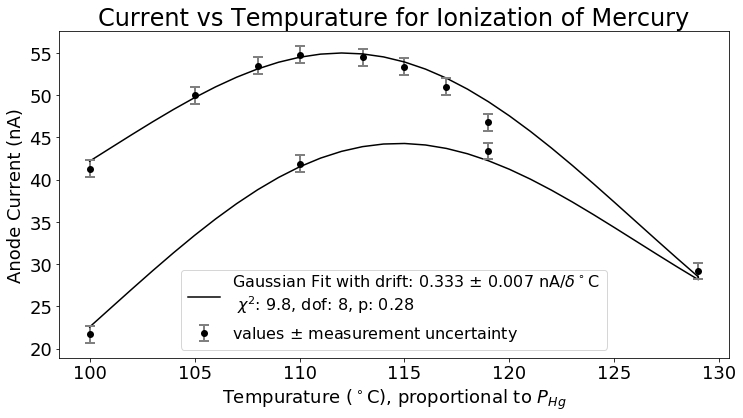

In [63]:
# get the fit
gauss_temps = np.linspace(np.min(ionization['temp'][6:18]), np.max(ionization['temp'][6:18]), 30)
gauss_temps = np.append(gauss_temps, gauss_temps[::-1])
data = np.ravel([gauss_temps, range(len(gauss_temps))])
corrected_fit = drift_gauss(data, *popt)

fig, ax = plt.subplots(1, figsize=(12, 6))

#make a fit label
fit_label = 'Gaussian Fit with drift: {:.3f} $\pm$ {:.3f} nA/$\delta^\circ$C'.format(popt[3], drift_change)
# p from http://courses.atlas.illinois.edu/spring2016/STAT/STAT200/pchisq.html
fit_label = fit_label + '\n $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi, len(temps)-len(popt), 0.2765)
ax.plot(gauss_temps, corrected_fit, 'black', label=fit_label)
ax.errorbar(temps, ionization['temp_current'][6:18], label='values $ \pm $ measurement uncertainty', yerr=ionization['temp_current_unc'][6:18], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Current vs Tempurature for Ionization of Mercury')
ax.set_xlabel('Tempurature ($^\circ$C), proportional to $P_{Hg}$')
ax.set_ylabel('Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)


#so drift is about .3326 per degree
ax.legend(fontsize=16)
plt.show()

In [64]:
# now plot corretcted for drift over full range

full_times = list()
full_times.append(0.0)
for i in range(1, 18):
    full_times.append(abs(ionization['temp'][i] - ionization['temp'][i-1]) + full_times[-1])
    #full_times.append(i)

drifts = [popt[3]*f for f in full_times]
corrected_current = ionization['temp_current'][:18] - drifts
drift_uncerts = [drift_change * f + 2*popt[3] for f in full_times]

# combine 6, 17 and 7, 14
corrected_current[17] = (corrected_current[6] + corrected_current[17])/2
corrected_current[14] = (corrected_current[7] + corrected_current[14])/2
corrected_current[10] = (corrected_current[8] + corrected_current[10])/2

Text(0.23,0.5,'Current at 110$^\\circ$C: \n\t 38.8 $ \\pm $ 1.0 (stat.) $ \\pm $ 1.5 (syst.) nA')

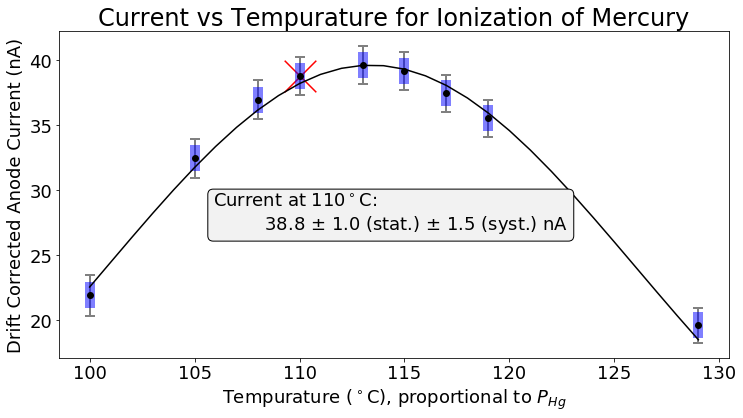

In [65]:
# make a pretty plot

# drift corrected fit
gauss_temps = np.linspace(np.min(ionization['temp'][6:18]), np.max(ionization['temp'][6:18]), 30)
data = np.ravel([gauss_temps, np.zeros(len(gauss_temps))])
corrected_fit = drift_gauss(data, *popt)


fig, ax = plt.subplots(1, figsize=(12, 6))
# plot fit
ax.plot(gauss_temps, corrected_fit, 'black', label='fit A=%2.1f, mean=%5.0f, sigma=%1.0f' % tuple(popt[:3]))
# plot points and uncertainty from drifts (systematic)
ax.errorbar(temps[3:], corrected_current[9:18] + ionization['temp_current'][6], yerr=drift_uncerts[9:18], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
# plot uncertainty from repeated measurments and measurment uncertainty 
stat_uncerts = ionization['temp_current_unc'][9:18]
ax.errorbar(temps[3:], corrected_current[9:18] + ionization['temp_current'][6], yerr=stat_uncerts, fmt='None', c='red', alpha=0.5, ecolor='blue', capsize=0, elinewidth=10, markeredgewidth=2, ms=10)

ax.set_title('Current vs Tempurature for Ionization of Mercury')
ax.set_xlabel('Tempurature ($^\circ$C), proportional to $P_{Hg}$')
ax.set_ylabel('Drift Corrected Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

plt.scatter(110, corrected_current[14] + ionization['temp_current'][6], marker='x', s=1000, c='r')
ax.annotate('Current at 110$^\circ$C: \n\t {:.1f} $ \pm $ {:.1f} (stat.) $ \pm $ {:.1f} (syst.) nA'.format(corrected_current[14] + ionization['temp_current'][6], ionization['temp_current_unc'][14], drift_uncerts[14]), 
            xy=(.23, .5), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


### Ionization
yay

In [66]:
voltages = ionization['V_gc']
currents = ionization['V_gc_current']
uncerts = ionization['V_gc_current_unc']*10

# p0 is the initial guess for the fitting coefficients 
p0 = [.1, 0, 8, -100]
popt, pcov = curve_fit(lines, voltages, currents, p0=p0, sigma=uncerts)
print(popt)
log_volts = np.linspace(np.min(voltages), np.max(voltages), 50)
log_corrected_fit = lines(log_volts, *popt)

p0 = [8, -100]
voltages2 = ionization[ionization['V_gc_current']>10]['V_gc']
currents2 = ionization[ionization['V_gc_current']>10]['V_gc_current']
uncerts2 = ionization[ionization['V_gc_current']>10]['V_gc_current_unc']*10
popt2, pcov2 = curve_fit(line, voltages2, currents2, p0=p0, sigma=uncerts2)
print(popt2)

[   0.24214261   -2.84357195   10.16156131 -193.66550831]
[   8.14970998 -146.28250035]


In [67]:
# find the intercepts
intercept = (popt[3]-popt[1])/(popt[0]-popt[2])
intercept2 = (popt2[1]-popt[1])/(popt[0]-popt2[0])
print(intercept)
print(intercept2)
print('\n\n')

# find bounds on the intercepts 
mu1_change = .039
b1_change=.8

mu2_change = .059
b2_change=1.31


#find chi squareds
orig_chi_1 = chi_squared(currents, lines(voltages, *popt), uncerts)
up_chi_m1 = chi_squared(currents, lines(voltages, *popt[:2], popt[2] + mu1_change, popt[3]), uncerts)
down_chi_m1 = chi_squared(currents, lines(voltages, *popt[:2], popt[2] - mu1_change, popt[3]), uncerts)
#print('M1 Chi Squared(Up): {:.2f}, Difference:{}'.format(up_chi, up_chi-orig_chi))
#print('Reduced Chi Squared(Down): {:.2f}, Differnece: {}'.format(down_chi, down_chi-orig_chi))
print('M1 Average Difference: {}\n'.format((up_chi_m1+down_chi_m1-2*orig_chi_1)/2))
                                          
up_chi_b1 = chi_squared(currents, lines(voltages, *popt[:3], popt[3] + b1_change), uncerts)
down_chi_b1 = chi_squared(currents, lines(voltages, *popt[:3], popt[3] - b1_change), uncerts)
print('B1 Average Difference: {}\n'.format((up_chi_b1+down_chi_b1-2*orig_chi_1)/2))

orig_chi_2 = chi_squared(currents2, line(voltages2, *popt2), uncerts2)
up_chi_b2 = chi_squared(currents2, line(voltages2, popt2[0], popt2[1] + b2_change), uncerts2)
down_chi_b2 = chi_squared(currents2, line(voltages2, popt2[0], popt2[1] - b2_change), uncerts2)
print('B2 Average Difference: {}\n'.format((up_chi_b2+down_chi_b2-2*orig_chi_2)/2))
up_chi_m2 = chi_squared(currents2, line(voltages2, popt2[0]+mu2_change, popt2[1]), uncerts2)
down_chi_m2 = chi_squared(currents2, line(voltages2, popt2[0]-mu2_change, popt2[1]), uncerts2)
print('M2 Average Difference: {}\n'.format((up_chi_m2+down_chi_m2-2*orig_chi_2)/2))
                                          

print('Chi: ' + str(orig_chi_2))
print('dof: '  +str(len(voltages)-len(popt)))
print('Reduced Chi: ' + str(orig_chi_2/(len(voltages)-len(popt))))

# find intercept changes
dint_1 = max(abs((popt[3]+b1_change-popt[1])/(popt[0]-popt[2]-mu1_change) - intercept), abs((popt[3]-popt[1]-b1_change)/(popt[0]-popt[2]+mu1_change) -intercept))
dint_2 = max(abs((popt2[1]+b2_change-popt[1])/(popt[0]-popt2[0]-mu2_change) - intercept2), abs((popt2[1]-popt[1]-b2_change)/(popt[0]-popt2[0]+mu2_change) -intercept2))
print('intercept one: {} +- {}'.format(intercept, dint_1))
print('intercept two: {} +- {}'.format(intercept2, dint_2))

19.237209556090253
18.139450672498054



M1 Average Difference: 1.0306970279098593

B1 Average Difference: 1.0381408955432505

B2 Average Difference: 1.0296600000000036

M2 Average Difference: 1.0042609949639778

Chi: 0.8388160719803814
dof: 20
Reduced Chi: 0.04194080359901907
intercept one: 19.237209556090253 +- 0.15690136405046218
intercept two: 18.139450672498054 +- 0.3032690521575958


Text(0.03,0.5,'Ionization + Contact Potential: \n\t19.24 $ \\pm $ 1.10 (syst.) $ \\pm $ 0.34 (stat.) V')

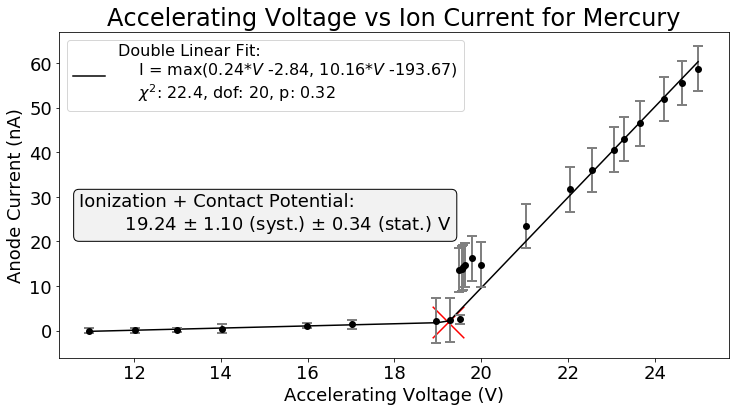

In [68]:
# make a pretty plot

fig, ax = plt.subplots(1, figsize=(12, 6))

# plot the fit
log_fit_label = 'Double Linear Fit: \n    I = max({:1.2f}$*V$ {:1.2f}, {:1.2f}$*V$ {:1.2f})'.format(*popt) 
log_fit_label  = log_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi_1, len(voltages)-len(popt), 0.3192)
ax.plot(log_volts, log_corrected_fit, 'black', label=log_fit_label)

# plot the points
ax.errorbar(ionization['V_gc'], ionization['V_gc_current'], label=None, yerr=uncerts, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Accelerating Voltage vs Ion Current for Mercury')
ax.set_xlabel('Accelerating Voltage (V)')
ax.set_ylabel('Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)
ax.legend(fontsize=16)
ax.scatter(intercept, popt[0]*intercept+popt[1] , marker='x', s=1000, c='r', linewidths=10)


ax.annotate('Ionization + Contact Potential: \n\t{:.2f} '.format(intercept) + r'$ \pm $' + ' {:.2f} (syst.) '.format(intercept-intercept2) + r'$ \pm $' + ' {:.2f} (stat.) V'.format(np.sqrt(dint_1**2 + dint_2**2)), 
            xy=(.03, .5), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


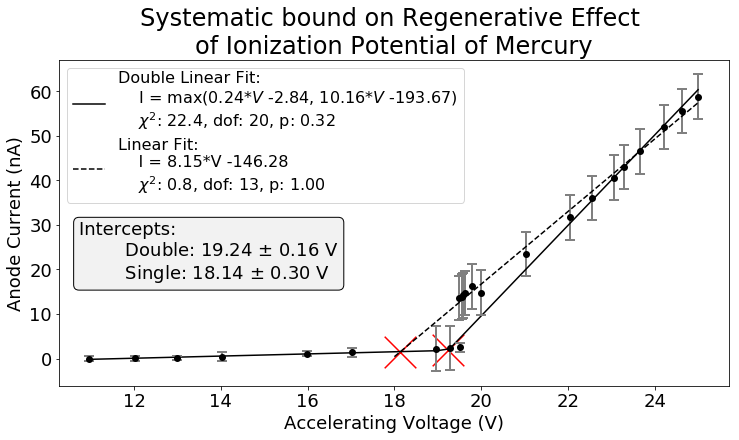

In [69]:
# make a pretty plot

fig, ax = plt.subplots(1, figsize=(12, 6))
# plot the double linear fit
ax.plot(log_volts, log_corrected_fit, 'black', label=log_fit_label)

# plot the points
ax.errorbar(ionization['V_gc'], ionization['V_gc_current'], yerr=uncerts, label=None, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Systematic bound on Regenerative Effect \nof Ionization Potential of Mercury')
ax.set_xlabel('Accelerating Voltage (V)')
ax.set_ylabel('Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

# plot the slingle linear fit
log_volts = np.linspace(18, np.max(voltages), 50)
log_corrected_fit = line(log_volts, *popt2)
log_fit_label = 'Linear Fit: \n    I = {:1.2f}*V {:1.2f}'.format(*popt2) 
log_fit_label  = log_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi_2, len(voltages2)-len(popt2), 1)
ax.plot(log_volts, log_corrected_fit, 'black', label=log_fit_label, linestyle='--')
ax.legend(fontsize=16)
ax.scatter(intercept, popt[0]*intercept+popt[1] , marker='x', s=1000, c='r', linewidths=10)
ax.scatter(intercept2, popt2[0]*intercept2+popt2[1], marker='x', s=1000, c='r', linewidths=10)

ax.annotate('Intercepts: \n\tDouble: {:.2f} $ \pm $ {:.2f} V\n\tSingle: {:.2f} $ \pm $ {:.2f} V'.format(intercept, dint_1, intercept2, dint_2), 
            xy=(.03, .5), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


plt.show()

In [188]:
excite = pd.read_table('excitaion.csv', sep=',')
excite['unc_1'] =excite['unc_1']*3
excite['unc_2'] =excite['unc_2']*3
excite['unc_3'] =excite['unc_3']*3

excite.head()

,V_gc_1,current_1,unc_1,V_gc_2,current_2,unc_2,V_gc_3,current_3,unc_3
0,0.042,0.01,0.06,0.0412,-0.001,0.009,5.00,-0.001,0.003
1,1.056,-0.01,0.06,5.0000,-0.002,0.009,9.99,-0.040,0.090
2,2.021,0.01,0.06,10.0100,-0.040,0.060,11.01,-0.200,0.300
3,3.027,0.01,0.06,11.0000,-0.015,0.120,12.00,-14.000,0.600
4,4.020,0.01,0.06,12.0000,-24.000,3.000,13.00,-22.000,3.000


In [192]:
print(len(excite[excite['V_gc_1']<10]))

15


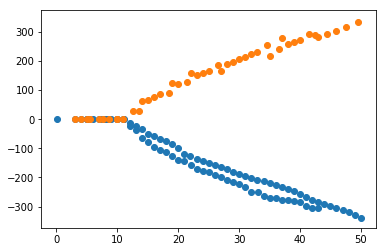

[ 0.06        0.06        0.06        0.06280616  0.06        0.11094812
  0.12400962  0.09        0.06        0.35581358 10.88273722  9.00630097
  6.          7.37158819  7.79585226  7.7461468   9.07918736  0.03
  7.90048213  6.65479668  0.3         6.36396103  6.39931637  6.45141833
 10.50760284  0.6         7.23016684  6.85302492  6.87070259  7.65443091
  9.20415497  8.85983998 16.13404496  0.6        10.47253271  0.6
  9.79657337  7.23016684 10.96199517 10.27582337  8.02880641  0.9
  1.99757666  0.3         2.17435335  1.92686598]


In [255]:
# for retarding diff
excite['V_gc_1'] = excite['V_gc_1'] + 1.1 -.512
excite.head()

# lets actually just fix the data - only take 1 and 2 and look at their average
volts = np.asarray(excite['V_gc_2'].append(excite['V_gc_3']).append(excite[excite['V_gc_1']<10]['V_gc_1']))
volts = volts[np.logical_not(np.isnan(volts))]
volts_sort = sorted(volts)

currents = np.asarray(excite['current_2'].append(excite['current_3']).append(excite[excite['V_gc_1']<10]['current_1']))
currents = currents[np.logical_not(np.isnan(currents))]
currents_sort = [x for _,x in sorted(zip(volts,currents))]

unc = np.asarray(excite['unc_2'].append(excite['unc_3']).append(excite[excite['V_gc_1']<10]['unc_1']))
unc = unc[np.logical_not(np.isnan(unc))]
unc_sort = [x for _,x in sorted(zip(volts,unc))]


volts_combined = list()
currents_combined = list()
unc_combined = list()
for i in range(1, len(volts_sort)):
    if int(volts_sort[i]) == int(volts_sort[i-1]):
        volts_combined[-1] = (volts_combined[-1] + volts_sort[i])/2
        currents_combined[-1] = (currents_combined[-1] + currents_sort[i])/2
        unc_combined[-1] = np.std([currents_combined[-1], currents_sort[i]])/np.sqrt(2) + np.sqrt((unc_sort[i]**2 + unc_combined[-1]**2))
    else:
        volts_combined.append(volts_sort[i])
        currents_combined.append(currents_sort[i])
        unc_combined.append(unc_sort[i])
        
        
volts_combined = np.asarray(volts_combined)
currents_combined= -np.asarray(currents_combined)
unc_combined = np.asarray(unc_combined)

plt.scatter(volts, currents)
plt.scatter(volts_combined, currents_combined)
plt.show()

print(unc_combined)

In [298]:
# do a curve fit 

def zero_line(data, *p):
    m1, b1 = p
    one = m1*data+b1
    return np.maximum(0, one)


p0 = [13, -130]
cutoff=17

volts = volts_combined[volts_combined<cutoff]
print(len(volts))

currents = currents_combined[volts_combined<cutoff]

uncerts = unc_combined[volts_combined<cutoff]

popt, pcov = curve_fit(zero_line, volts, currents, p0=p0, sigma=uncerts)
print(popt)


# find the intercept
intercept = - popt[1]/popt[0]

# find bounds on the intercepts 
mu_change = .045
b_change=.36


#find chi squareds
orig_chi = chi_squared(currents, zero_line(volts, *popt), uncerts)
up_chi_m = chi_squared(currents, zero_line(volts, popt[0] + mu_change, popt[1]), uncerts)
down_chi_m = chi_squared(currents, zero_line(volts, popt[0] - mu_change, popt[1]), uncerts)
print(up_chi_m)
print(down_chi_m)
print('Mu Average Difference: {}\n'.format((up_chi_m+down_chi_m-2*orig_chi)/2))
                                          
up_chi_b = chi_squared(currents, zero_line(volts, popt[0], popt[1] + b_change), uncerts)
down_chi_b = chi_squared(currents, zero_line(volts, popt[0], popt[1] + b_change), uncerts)
print('B Average Differnce: {}\n'.format((up_chi_b+down_chi_b-2*orig_chi)/2))                                        

print('Chi: ' + str(orig_chi))
print('dof: '  +str(len(volts)-len(popt)))
print('Reduced Chi: ' + str(orig_chi/(len(volts)-len(popt))))

# find intercept changes
dint = max(abs(-(popt[1]+b_change)/(popt[0]-mu_change) - intercept), abs(-(popt[1]-b_change)/(popt[0]+mu_change) - intercept))
print('intercept one: {} +- {}'.format(intercept, dint))

15
[  16.67084255 -183.34577216]
10.447478000112657
8.674078933278281
Mu Average Difference: 1.0855896213956626

B Average Differnce: 1.0344794433236029

Chi: 8.475188845299806
dof: 13
Reduced Chi: 0.6519376034846005
intercept one: 10.99799075073955 +- 0.008114450944932017


10.99799075073955


Text(0.03,0.8,'Contact Potential:\n\t9.90 $ \\pm $ 0.01 (stat.)$ \\pm $ 0.03 (syst.) V')

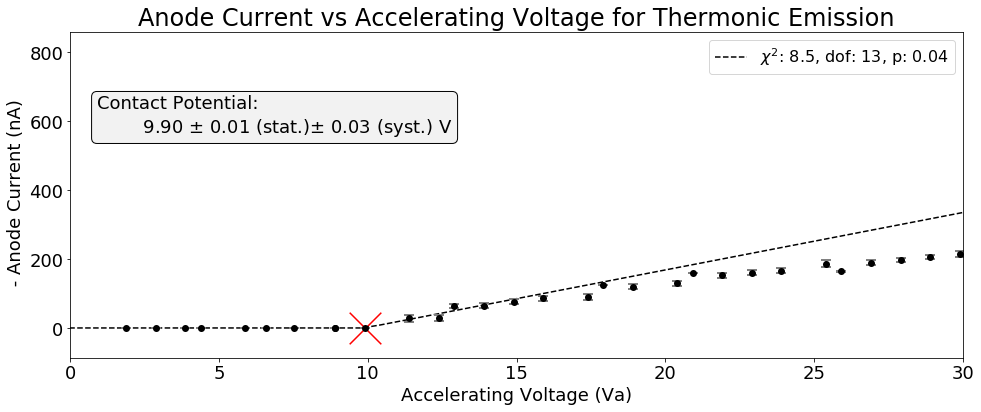

In [299]:
# make a pretty plot for contact potential

fig, ax = plt.subplots(1, figsize=(16, 6))

log_volts = np.linspace(0, 60, 100)
log_corrected_fit = zero_line(log_volts, *popt)
log_fit_label  = '$\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi, len(volts)-len(popt), 0.0394)

ax.plot(log_volts-1.1, log_corrected_fit, 'black', linestyle='--', label=log_fit_label)
ax.legend(fontsize=16)
ax.errorbar(volts_combined-1.1,currents_combined, yerr=unc_combined, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
ax.scatter(intercept-1.1, popt[0]*intercept+popt[1] , marker='x', s=1000, c='r', linewidths=10)

ax.set_title('Anode Current vs Accelerating Voltage for Thermonic Emission')
ax.set_xlabel('Accelerating Voltage (Va)')
ax.set_ylabel(' - Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)
ax.set_xlim(0, 30)

print(intercept)
# .03 system from uncertainty in subtracting Vr
ax.annotate('Contact Potential:\n\t{:.2f} '.format(intercept-1.1) + r'$ \pm $' + ' {:.2f} (stat.)'.format(dint) 
            + r'$ \pm $' + ' {:.2f} (syst.) V'.format(.03), 
            xy=(.03, .8), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


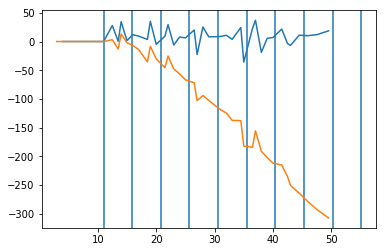

In [300]:
# look at the point to point difference? 
# fit a log?
for x in [4.9*i + 11 for i in range(10)]:
    plt.axvline(x=x)
plt.plot(volts_combined[1:], currents_combined[1:] - currents_combined[:-1])
plt.plot(volts_combined, currents_combined-zero_line(volts_combined, *popt))
plt.show()

[-193.66550617   10.16156121]


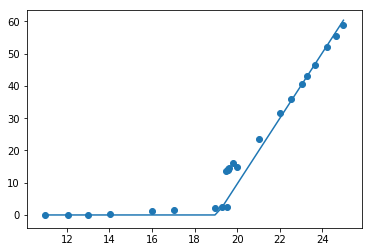

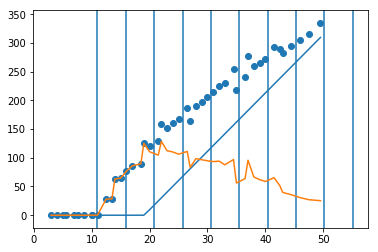

In [351]:
# subract of ionization??
def zero_log(data, *p):
    a, b= p
    return np.maximum(0, a+ b*data)


p0 = [-500, 100]
popt, pcov = curve_fit(zero_log, ionization['V_gc'], ionization['V_gc_current'], p0=p0, sigma=ionization['V_gc_current_unc'])
print(popt)

plt.plot(sorted(ionization['V_gc']), zero_log(np.asarray(sorted(ionization['V_gc'])), *popt))
plt.scatter(ionization['V_gc'], ionization['V_gc_current'])
plt.show()

plt.plot(volts_combined, zero_log(volts_combined, *popt))
plt.scatter(volts_combined, currents_combined)

for x in [4.9*i + 11 for i in range(10)]:
    plt.axvline(x=x)
plt.plot(volts_combined, currents_combined-zero_log(volts_combined, *popt))
plt.show()

[-5.27831327e+01  7.93906888e+00  2.61374114e-02 -8.85607487e-01]


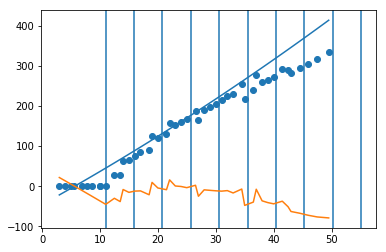

In [406]:
def zero_log(data, *p):
    a, b, c, d= p
    return np.maximum(0, a + b*np.exp(-c*(np.sqrt(data)-d)))
    #return a+b*(data-d)+c*(data-d)**2

min_cut=20
max_cut=20

#p0 = [-100, 10, 100, 10]
#p0 = [500, -500, .1, 3]
popt, pcov = curve_fit(zero_log, np.append(volts_combined[:min_cut], volts_combined[max_cut:]), 
                       np.append(currents_combined[:min_cut],currents_combined[max_cut:]), p0=p0, sigma=np.append(unc_combined[:min_cut],unc_combined[max_cut:]))
print(popt)
plt.plot(volts_combined, zero_log(volts_combined, *popt))
plt.scatter(volts_combined, currents_combined)

#plt.plot(excite['V_gc_2'], -excite['current_2']-zero_log(excite['V_gc_2'], *popt))
#plt.plot(excite['V_gc_3'], -excite['current_3']-zero_log(excite['V_gc_3'], *popt))

for x in [4.9*i + 11 for i in range(10)]:
    plt.axvline(x=x)
plt.plot(volts_combined, currents_combined-zero_log(volts_combined, *popt))
plt.show()

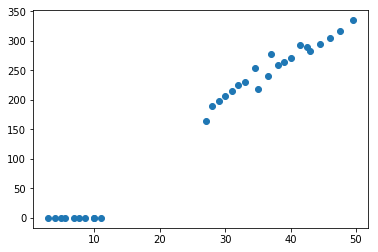

In [377]:
plt.scatter(np.append(volts_combined[:10], volts_combined[25:]), np.append(currents_combined[:10],currents_combined[25:]))
plt.show()

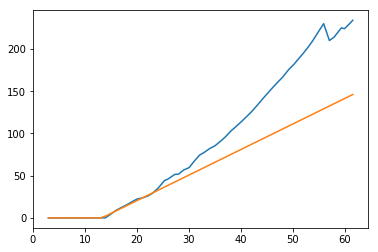

/home/kal/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in maximum
  # This is added back by InteractiveShellApp.init_path()


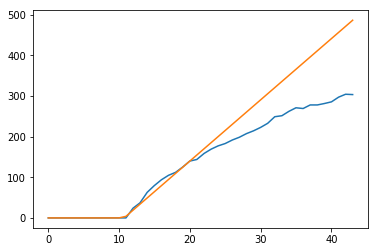

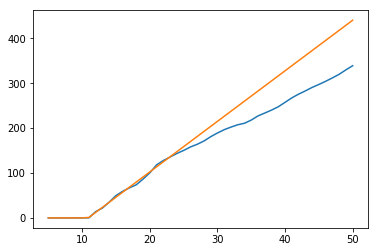

In [292]:
# try to get good excitation data
# look only at first bit?? before on linear effects begin - up until 30

fit=dict()
diffs=dict()
for i in range(1,4):
    volts = excite[excite['V_gc_'+str(i)]<25]['V_gc_'+str(i)][np.logical_not(np.isnan(excite['V_gc_'+str(i)]))]
    currents = excite[excite['V_gc_'+str(i)]<25]['current_'+str(i)][np.logical_not(np.isnan(excite['current_'+str(i)]))]
    uncerts = excite[excite['V_gc_'+str(i)]<25]['unc_'+str(i)][np.logical_not(np.isnan(excite['unc_'+str(i)]))]

    p0 = [.1, 0, 8, -100]
    popt, pcov = curve_fit(lines, volts, -currents, p0=p0, sigma=uncerts)

    fit[i] = lines(excite['V_gc_'+str(i)], *popt)
    plt.plot(excite['V_gc_'+str(i)], -excite['current_'+str(i)])
    plt.plot(excite['V_gc_'+str(i)], fit[i])
    plt.show()

    diffs[i] = fit[i] + excite['current_'+str(i)]

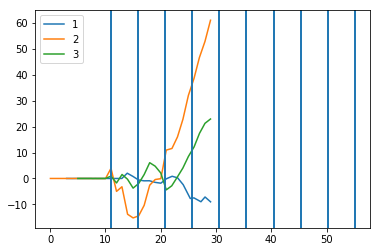

In [293]:
for i in range(1, 4):
    plt.plot(excite[excite['V_gc_'+str(i)]<30]['V_gc_'+str(i)], diffs[i][excite['V_gc_'+str(i)]<30], label=i)
    plt.legend()
    for x in [4.9*i + 11 for i in range(10)]:
        plt.axvline(x=x)
plt.show()

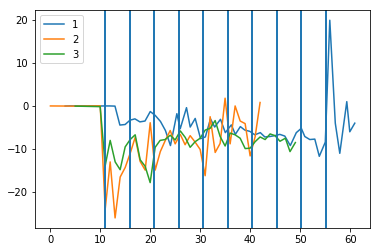

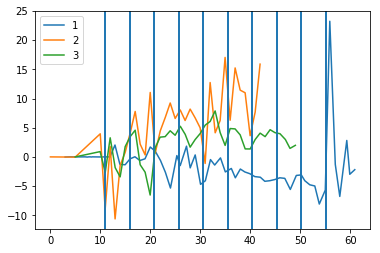

In [283]:
for i in range(1, 4):
    slope = [a-b for a,b in zip(excite['current_'+str(i)][1:], excite['current_'+str(i)][:-1])]
    plt.plot(excite['V_gc_'+str(i)][:-1], slope, label=i)
    plt.legend()
    for x in [4.9*i + 11 for i in range(10)]:
        plt.axvline(x=x)
plt.show()


for i in range(1, 4):
    slope = [a-b for a,b in zip(diffs[i][1:], diffs[i][:-1])]
    plt.plot(excite['V_gc_'+str(i)][:-1], slope, label=i)
    plt.legend()
    for x in [4.9*i + 11 for i in range(10)]:
        plt.axvline(x=x)
plt.show()

### contact potential

In [77]:
calib = pd.read

AttributeError: module 'pandas' has no attribute 'read'

In [ ]:
a[1:]